In [31]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
import numpy as np

import lightgbm as lgb

/Users/xszpo/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
import helpers

In [4]:
import pymongo

In [5]:
seed = 666

In [6]:
mongo_adrress = 'localhost'
mongo_port = 27017
mongo_username = 'xflats'
mongo_password = 'xflats'
dbase = 'OFFERS'

connection = pymongo.MongoClient(host=mongo_adrress, port=mongo_port, username=mongo_username,
                                 password=mongo_password, authSource='admin', authMechanism='SCRAM-SHA-256',
                                 serverSelectionTimeoutMS=5000)
db = connection[dbase]

# Target - price

In [7]:
target_olx = [i['price'] for i in db['olx'].find({},{'_id':0, 'price':1})]

In [8]:
target_gratka = [i['price'] for i in db['gratka'].find({},{'_id':0, 'price':1}) if i['price']<2000000]

In [9]:
target_morizon = [i['price'] for i in db['morizon'].find({},{'_id':0, 'price':1})]

In [10]:
target_otodom = [i['price'] for i in db['otodom'].find({},{'_id':0, 'price':1})]

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'price in pln')]

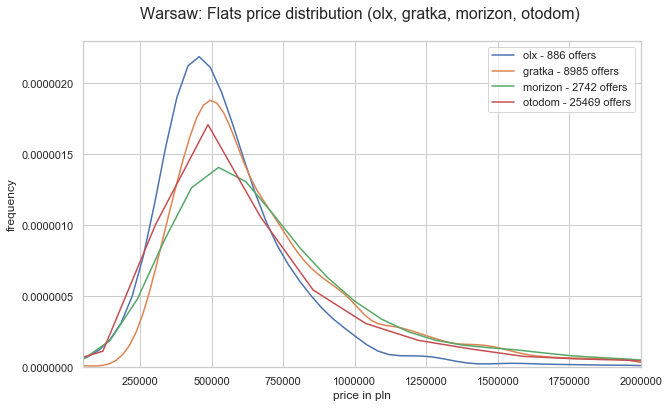

In [11]:
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
plt.xlim(50000, 2000000)

sns.distplot(target_olx, rug=False, hist=False, ax=ax1, label='olx - {} offers'.format(len(target_olx)))
sns.distplot(target_gratka, rug=False, hist=False, ax=ax1, label='gratka - {} offers'.format(len(target_gratka)))
sns.distplot(target_morizon, rug=False, hist=False, ax=ax1, label='morizon - {} offers'.format(len(target_morizon)))
sns.distplot(target_otodom, rug=False, hist=False, ax=ax1, label='otodom - {} offers'.format(len(target_otodom)))
plt.title('Warsaw: Flats price distribution (olx, gratka, morizon, otodom) ', y=1.05, fontsize = 16)
ax1.set(xlabel='price in pln', ylabel='frequency')



# Map

In [12]:
with open("../gmap_key.key", "r") as file:
    key = file.readline().strip()

In [13]:
import pandas as pd
mapa = pd.DataFrame([i for i in db['gratka'].find({},{'_id':1, 'price':1,'url':1,'producer_name':1, 'GC_latitude':1, 'GC_longitude':1})])
mapa = mapa.head(2)
mapa

,_id,price,url,producer_name,GC_latitude,GC_longitude
0,gra_14318819_42900000,429000,https://gratka.pl/nieruchomosci/mieszkanie-48-...,gratka,52.295699,21.026206
1,gra_14245751_59000000,590000,https://gratka.pl/nieruchomosci/bezposrednio-3...,gratka,52.257604,20.979788


# Features

## get data

In [14]:
type(True)

bool

In [15]:
import re

def clean_str(value):
    """
    Remove white spaces, and transform text to lower
    
    :param txt: string to clean 
    :return: cleaned string or other object - with no transformation
    """
    if type(value) == str:
        pattern = re.compile(r'\s+')
        return re.sub(pattern, ' ', value).strip().lower()
    else:
        return value

    
def add_2_desc(dict_, txt_field, desc_field='description'):
    if txt_field in dict_.keys():
        if dict_[txt_field] is not None and type(dict_[txt_field]) != list:
            return dict_[desc_field]+" "+txt_field+" "+ dict_[txt_field]
        if dict_[txt_field] is not None and type(dict_[txt_field]) == list:
            return dict_[desc_field]+" "+txt_field+" "+ " ".join(dict_[txt_field])
        else:
            return dict_[desc_field]
    else:
        return dict_[desc_field]
    
def add_none(dict_, field):
    if field not in dict_.keys():
        dict_[field] = None
    return dict_[field]


def clean_data(data):
    """
    Perform primary data cleaning.
    
    :param data: data from mongo, list or dict
    :return: cleaned string or other object - with no transformation
    """
    list_ = []
    
    if type(data)==dict:
        data_ = [data.copy()]
    elif type(data)==list:
        data_ = data.copy()
    else:
        data_ = None
    
    for rec in data_:
        _tmp = {}
        for i in rec.keys():
            _tmp[i] = clean_str(rec[i])
        
        if _tmp['name'] is None:
            _tmp['name'] = 'no_value'
        
        _tmp['description'] = _tmp['description'] +" PASTA: "
        
        for key in ['additional_info',
                    'building_type',
                    'building_material',
                    'property_form',
                    'market',
                    'widows_type',
                    'heating_type',
                    'finishing_stage',
                    'property_form',
                    'comute',
                    'health_beauty',
                    'education',
                    'other',
                    'parking',
                    'kitchen',
                    'umeblowane',
                    'condition',
                    'condition_electric_wires',
                    'windows',
                    'loudness',
                    'bathroom_equip',
                    'bathroom',
                    'bathroom_number',
                    'additional_space',
                    'world_direction',
                    'terrace',
                    'for_office']:
            _tmp['description'] = add_2_desc(_tmp, key,  'description')

        for key in ['year_of_building','number_of_floors','terrece_size','flat_height']:
            _tmp[key] = add_none(_tmp, key)
        
        list_ += [_tmp]
    
    return list_



In [16]:
raw_data = [i for i in db['morizon'].find({})]
list_morizon = clean_data(raw_data)
raw_data = [i for i in db['otodom'].find({})]
list_otodom = clean_data(raw_data)
raw_data = [i for i in db['olx'].find({})]
list_olx = clean_data(raw_data)
raw_data = [i for i in db['gratka'].find({})]
list_gratka = clean_data(raw_data)
del(raw_data)

In [17]:
flds_id = ['_id',]
flds_target = ['price']
flds_num = ['flat_size','rooms','floor','number_of_floors','year_of_building']
flds_num_geo = ['GC_latitude','GC_longitude']
flds_cat = ['producer_name']
flds_cat_geo =['GC_addr_road','GC_addr_neighbourhood','GC_addr_suburb','GC_addr_city','GC_addr_state','GC_addr_postcode','GC_addr_country']
flds_text = ['description']
flds_drop = ['location']
download_date = ['download_date','name']
all_fields = flds_id+flds_target+flds_num+flds_num_geo+flds_cat+flds_cat_geo+flds_text+download_date+flds_drop


In [18]:
df_morizon = pd.DataFrame(list_morizon)[all_fields]
df_otodom = pd.DataFrame(list_otodom)[all_fields]
df_olx = pd.DataFrame(list_olx)[all_fields]
df_gratka = pd.DataFrame(list_gratka)[all_fields]

df = pd.concat([df_morizon, df_otodom, df_olx, df_gratka])


In [34]:
list(df.columns)

['_id',
 'price',
 'flat_size',
 'rooms',
 'floor',
 'number_of_floors',
 'year_of_building',
 'GC_latitude',
 'GC_longitude',
 'producer_name',
 'GC_addr_road',
 'GC_addr_neighbourhood',
 'GC_addr_suburb',
 'GC_addr_city',
 'GC_addr_state',
 'GC_addr_postcode',
 'GC_addr_country',
 'description',
 'download_date',
 'name',
 'location',
 'fold']

In [19]:
df.sample(5, random_state=seed)

,_id,price,flat_size,rooms,floor,number_of_floors,year_of_building,GC_latitude,GC_longitude,producer_name,...,GC_addr_neighbourhood,GC_addr_suburb,GC_addr_city,GC_addr_state,GC_addr_postcode,GC_addr_country,description,download_date,name,location
22407,oto_59599784_1220000,1220000,97,4.0,3.0,6,2012,52.260413,20.973423,otodom,...,sady żoliborskie,żoliborz,warszawa,mazowieckie,01-794,rp,"bezpośrednio sprzedam nowocześnie urządzone, p...",2019-09-04 08:42:45.000,apartament żoliborz bezpośrednio,"warszawa, żoliborz"
13821,oto_59476163_511000,511000,68,3.0,1.0,1,2020,52.190540,20.868350,otodom,...,niedźwiadek,ursus,warszawa,mazowieckie,02-495,rp,lokalizacja: * bliskość stacji pkp ursus-niedź...,2019-09-04 11:12:14.000,rabaty do 30 tys!,"warszawa, ursus, mariana krawczyka"
2422,gra_12728581_80000000,800000,72,3.0,3.0,8,2009,52.240500,21.034200,gratka,...,vii,śródmieście,warszawa,województwo mazowieckie,00-340,polska,"opis ogłoszenia mieszkanie o powierzchni 71,90...",2019-11-04 19:36:18.140,mieszkanie warszawa mokotów,"warszawa, mokotów, mazowieckie"
382,mor_2034920659_499000,499000,54,3.0,10.0,10,1977,52.193512,21.062421,morizon,...,marcelin,mokotów,warszawa,województwo mazowieckie,02-904,polska,do sprzedaży słoneczne i ustawne mieszkanie. s...,2019-11-04 22:54:20.999,"warszawa, mokotów, bernardyńska","warszawa, mokotów, bernardyńska"
19255,oto_56340160_1188000,1188000,108,5.0,0.0,4,1928,52.216420,20.983350,otodom,...,stara ochota,ochota,warszawa,mazowieckie,02-051,rp,lokal o powierzchni 108 m2 na starej ochocie w...,2019-09-04 09:57:34.000,"idealne na biuro, mieszkanie i biuro, mieszkanie","warszawa, ochota, ochota, zygmunta glogera"


# Train test split

In [20]:
df = pd.concat([df_morizon, df_otodom, df_olx, df_gratka])

filter_query = "price <= 1500000 and price >= 100000 and flat_size <= 150"

df = df.query(filter_query)

df = df.sort_values(download_date[0],ascending=False).reset_index(drop=True)

oot_idx_l = list(range(int(np.floor(df.shape[0]*0.05))))
oot_idx_size = len(oot_idx_l)
model_idx_l = list(range(len(oot_idx_l),df.shape[0]))
model_idx_size = len(model_idx_l)
df.loc[oot_idx_l,'fold'] = 'oot'
df.loc[model_idx_l,'fold']=np.random.choice(['train', 'test'],model_idx_size,p=[0.9, 0.1]).tolist()


In [21]:
np.random.seed(666)

df_train = df[df['fold']=='train'].dropna(subset = ['price']).query(filter_query).reset_index(drop=True)
df_test = df[df['fold']=='test'].dropna(subset = ['price']).query(filter_query).reset_index(drop=True)
df_oot = df[df['fold']=='oot'].dropna(subset = ['price']).query(filter_query).reset_index(drop=True)

print("Test size: {:,}, Test size: {:,},  Out Of Time set size: {:,}".format(df_train.shape[0], df_test.shape[0], df_oot.shape[0]))


Test size: 30,197, Test size: 3,426,  Out Of Time set size: 1,769


[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'date')]

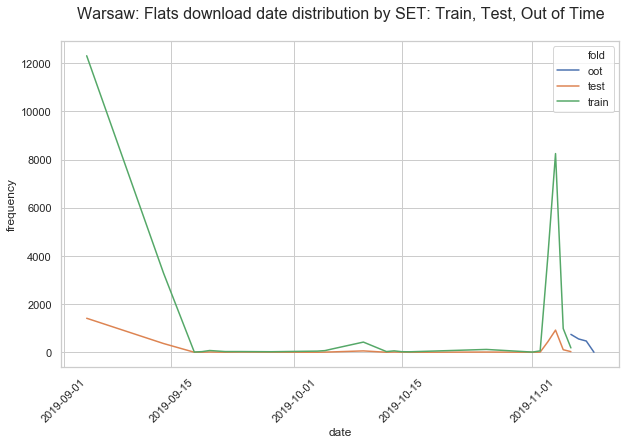

In [32]:
tmp_pl1 = df.assign(
    date = lambda x: x.download_date.apply(
        lambda x: pd.datetime.date(x)))[['fold','date','_id']].groupby(
    ['fold','date']).agg('count').reset_index().rename(columns={'_id':'cnt'})

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(x="date", y="cnt",
             hue="fold",
             data=tmp_pl1, ax=ax1)

plt.title('Warsaw: Flats download date distribution by SET: Train, Test, Out of Time', y=1.05, fontsize = 16)
plt.xticks(rotation=45)
ax1.set(xlabel='date', ylabel='frequency')



[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'price in pln')]

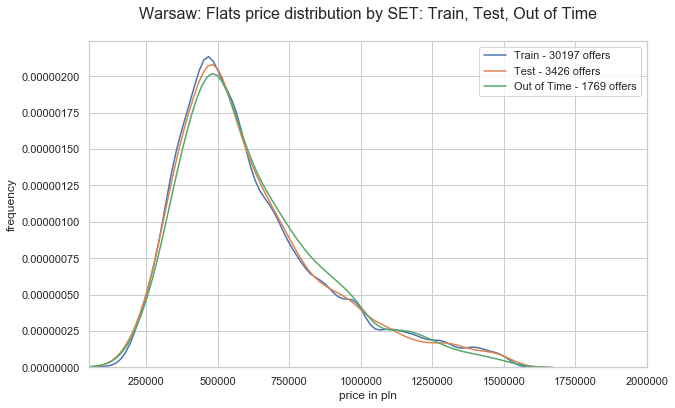

In [23]:
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
plt.xlim(50000, 2000000)

sns.distplot(df_train.price, rug=False, hist=False, ax=ax1, label='Train - {} offers'.format(df_train.shape[0]))
sns.distplot(df_test.price, rug=False, hist=False, ax=ax1, label='Test - {} offers'.format(df_test.shape[0]))
sns.distplot(df_oot.price, rug=False, hist=False, ax=ax1, label='Out of Time - {} offers'.format(df_oot.shape[0]))

plt.title('Warsaw: Flats price distribution by SET: Train, Test, Out of Time', y=1.05, fontsize = 16)
ax1.set(xlabel='price in pln', ylabel='frequency')


# Train basic model - no tuning, no features engineering

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

import lightgbm as lgb

In [25]:
params = {'colsample_bytree': 0.6624318354159208, #feature_fraction
 'learning_rate': 0.15990411055449805,
 'max_bin': 38712,
 'max_depth': 7,
 'min_child_samples': 84, #min_data_in_leaf
 'min_child_weight': 6, #min_sum_hessian_in_leaf
 'n_estimators': 206, #num_iterations
 'num_leaves': 159,
 'reg_alpha': 3.960667919705787e-06, #lambda_l1
 'reg_lambda': 499.85995495490215, #lambda_l2
 'subsample': 0.9022680042341511, #bagging_fraction
 'subsample_for_bin': 144116, #bin_construct_sample_cnt
 'subsample_freq': 0 #bagging_freq
         } 

In [26]:
np.random.seed(666)

pipe_lgb = make_pipeline(
    ColumnTransformer([
        ('cat', helpers.transformColList(),flds_cat+flds_cat_geo),
        ('num', helpers.PassThroughOrReplace(),flds_num+flds_num_geo),
        ('txt_name', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1,1), 
                               max_features=500, 
                               dtype=np.float32,
                               binary = True, 
                               use_idf=False),'name'),
        ('txt_dscr', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 3), 
                               max_features=3000, 
                               dtype=np.float32,
                               use_idf=True),'description'),
    ]),
    lgb.LGBMRegressor(**params, objective='regression_l2', random_state=666)
    )

In [27]:
%%time
y_log = np.log1p( df_train.price.tolist())
save = pipe_lgb.fit(df_train, y_log)


CPU times: user 6min 24s, sys: 30.6 s, total: 6min 55s
Wall time: 4min 26s


In [28]:
%%time

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error

y_pred = pipe_lgb.predict(df_train)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_train.price, y_pred)
med_abs_err = median_absolute_error(df_train.price, y_pred)
mean_abs_err = mean_absolute_error(df_train.price, y_pred)
print("Train set r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))

y_pred = pipe_lgb.predict(df_test)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_test.price, y_pred)
med_abs_err = median_absolute_error(df_test.price, y_pred)
mean_abs_err = mean_absolute_error(df_test.price, y_pred)

print("Test set r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))

y_pred = pipe_lgb.predict(df_oot)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_oot.price, y_pred)
med_abs_err = median_absolute_error(df_oot.price, y_pred)
mean_abs_err = mean_absolute_error(df_oot.price, y_pred)

print("Out of time set -  r2 score {}, median absolute error {}, mean absolute error {}".format(round(r2,4),int(med_abs_err), int(mean_abs_err)))



Train set r2 score 0.9185, median absolute error 30131, mean absolute error 49001
Test set r2 score 0.8961, median absolute error 33480, mean absolute error 55069
Out of time set -  r2 score 0.8716, median absolute error 37214, mean absolute error 59426
CPU times: user 2min 27s, sys: 13.9 s, total: 2min 41s
Wall time: 4min 16s


Plotting feature importances...


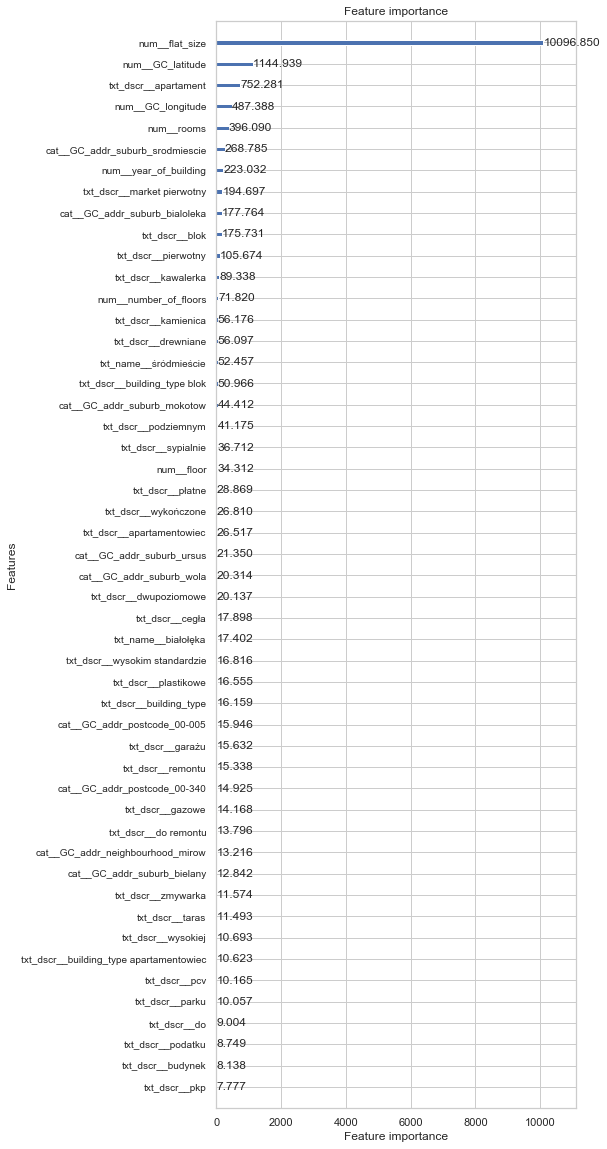

In [29]:
print('Plotting feature importances...')
def names(): return pipe_lgb.named_steps['columntransformer'].get_feature_names()
pipe_lgb.named_steps['lgbmregressor'].booster_.feature_name = names
fig, ax = plt.subplots(figsize=(10,20))
fig.subplots_adjust(left=0.4)
lgb.plot_importance(pipe_lgb.named_steps['lgbmregressor'], max_num_features=50, ax=ax, importance_type = 'gain')
plt.yticks(fontsize=10)
plt.show()